In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses

In [2]:
base_string = "()()" + (32 - 4) * " "

def shuffle_string(s):
    indices = np.arange(len(s), dtype='uint8')
    np.random.shuffle(indices)
    return "".join(base_string[i] for i in indices)

def is_correct(seq):
    open_brackets = 0
    val = {"(": 1, " ": 0, ")": -1}
    for c in seq:
        open_brackets += val[c]
        if open_brackets < 0:
            return False
    return open_brackets == 0

char2id = {" ": 0, "(": 1, ")": 2}

def generate_pairs(size):
    X = np.zeros((size, 3, len(base_string)), dtype='float32')
    Y = np.zeros((size), dtype='int64')
    for i in range(size):
        s = shuffle_string(base_string)
        Y[i] = int(is_correct(s))
        for j, c in enumerate(s):
            X[i, char2id[c], j] = 1.
    return X, Y

def generate_train_test_pairs(size):
    X, Y = generate_pairs(size)
    return train_test_split(X, Y, test_size=0.25, random_state=42)

In [3]:
x = shuffle_string(base_string)
print(x, "- correct" if is_correct(x) else "- incorrect")

                   )  ((   )     - incorrect


In [4]:
X_train, X_test, Y_train, Y_test = generate_train_test_pairs(1000)

trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)),
                         batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)),
                         batch_size=32, shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [5]:
class Recurrent(nn.Module):
    def __init__(self, rnn_size):
        super(Recurrent, self).__init__()
        self.gru = nn.GRU(input_size=3, hidden_size=rnn_size)
        self.fc = nn.Linear(rnn_size, 2)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        output, hidden = self.gru(x)
        return self.fc(hidden.squeeze(0))

In [6]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()

In [7]:
model = Recurrent(8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

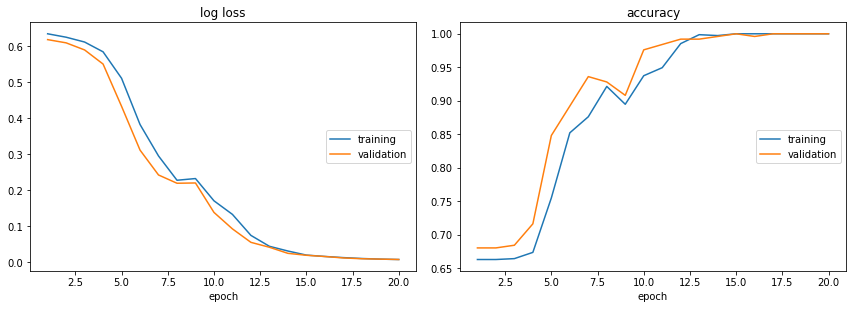

log loss:
training   (min:    0.007, max:    0.635, cur:    0.007)
validation (min:    0.007, max:    0.619, cur:    0.007)

accuracy:
training   (min:    0.663, max:    1.000, cur:    1.000)
validation (min:    0.680, max:    1.000, cur:    1.000)


In [8]:
train_model(model, criterion, optimizer, num_epochs=20)